## Base de dados mnist
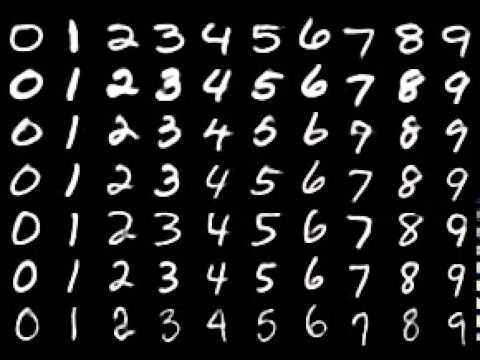

###### Importações

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

In [2]:
(previsores_treinamento, _), (previsores_teste, _) = mnist.load_data()

###### Redimensionamento das imagens

In [3]:
# dimensões 28x28 e 1 canal (escalas)
previsores_treinamento = previsores_treinamento.reshape((len(previsores_treinamento), 28, 28, 1))

In [4]:
# dimensões 28x28 e 1 canal (escalas)
previsores_teste = previsores_teste.reshape((len(previsores_teste), 28, 28, 1))

In [5]:
# escala de 0 e 1
previsores_treinamento = previsores_treinamento.astype('float32') / 255
previsores_teste = previsores_teste.astype('float32') / 255

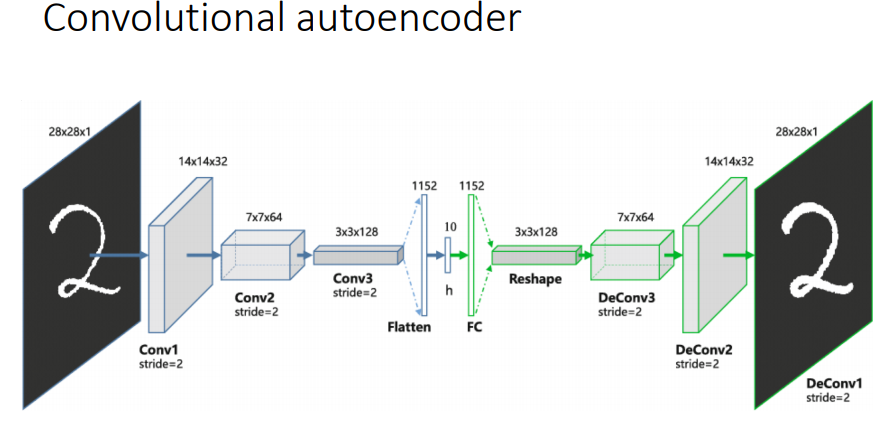

###### Etapa 1 - Conv2D
Detector de Características e Mapa de Características

    filters - Número de filtros (16, dimensões 3x3) 
    kernel_size - Dimensões do detector de características (3,3)
    activation -  Função de ativação para retirar os valores negativos da imagem 'relu'
    input_shape - Definição da altura/largura e canais RGB (28, 28, 1)
   
###### Etapa 2 - MaxPooling2D
Redução do tamanho da imagem focando nas caracteristicas mais importantes

    pool_size - Definição da matriz com o total de 4 pixels (2, 2)
   
###### Etapa 3 - Camadas ocultas
Definição das camadas ocultas
    
    padding - como a imagem será passada (caso não seja colocado é possivel ocorrer erro na execução)
    strides - de quantos em quantos pixels a imagem irá 'andar' (de 2 em 2)
    
###### Etapa 4 - Flattening
Transformação da matriz para um vetor para entrar na camada da RN

In [6]:
# Codificação

autoencoder = Sequential()
# Conv2D
autoencoder.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape=(28,28,1)))
# MaxPolling2D
autoencoder.add(MaxPooling2D(pool_size = (2,2)))
# Camada oculta
autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), padding='same'))
autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same', strides = (2,2)))
# Flattening
autoencoder.add(Flatten())
# 4, 4, 8 - (vetor de 128 dimensões)
autoencoder.add(Reshape((4,4,8)))

In [7]:
# Decodificação

autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same'))
autoencoder.add(UpSampling2D(size = (2,2)))
autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same'))
autoencoder.add(UpSampling2D(size = (2,2)))
# obs - ultimo elemento não deve ter padding 'same'
autoencoder.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'))
autoencoder.add(UpSampling2D(size = (2,2)))
# saída (apenas uma imagem como filtro)
autoencoder.add(Conv2D(filters = 1, kernel_size = (3,3), activation = 'sigmoid', padding='same'))

In [8]:
# Estrutura da rede neural
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 8)           0

###### Treinamento do Autoenconder

Parâmetros do otimizador:

    optimizer - descida do gradiente e descida do gradiente estocástica (adam é uma otimização do estocástica)
    loss - Função de perda (binary_crossentropy pois só há uma saída)
    metrics - Métrica de avaliação (obs - pode ser colocado mais de um)
    
Parâmetros do treinamento:

    X - Atributos previsores
    y - Atributos da classe (porém nós devemos comparar por si mesmo já que os dados apenas são redimensionados)
    epochs - número das épocas
    batch_size - tamanho do batch
    validation_data - dados de validação (Comparação da imagem antes de ser redimensionada e depois)

In [9]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

# auto tempo de processamento, coloquei apenas 10 épocas...
autoencoder.fit(previsores_treinamento, previsores_treinamento,
                epochs = 10, batch_size = 256, 
                validation_data = (previsores_teste, previsores_teste))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
235/235 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.7891WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000000DE93331318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

###### Codificação e decodificação

In [11]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten').output)
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten (Flatten)            (None, 128)              

In [13]:
imagens_codificadas = encoder.predict(previsores_teste)
imagens_decodificadas = autoencoder.predict(previsores_teste)

###### Observação da imagem original, codificada e reconstruída

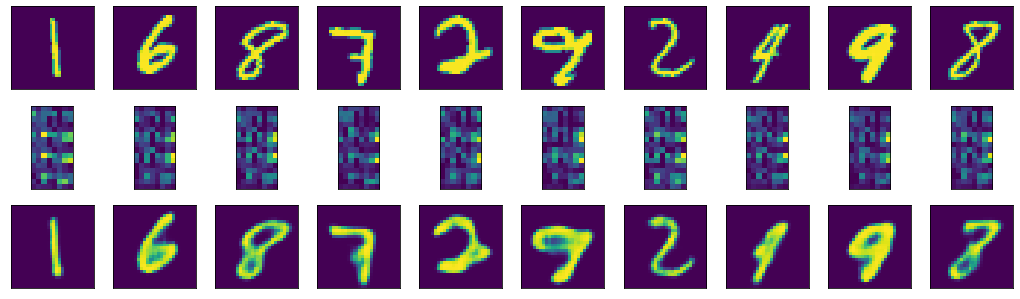

In [14]:
numero_imagens = 10
imagens_teste = np.random.randint(previsores_teste.shape[0], size = numero_imagens)
plt.figure(figsize=(18,18))
for i, indice_imagem in enumerate(imagens_teste):
    # imagem original
    eixo = plt.subplot(10,10,i + 1)
    plt.imshow(previsores_teste[indice_imagem].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
    
    # imagem codificada
    eixo = plt.subplot(10,10,i + 1 + numero_imagens)
    plt.imshow(imagens_codificadas[indice_imagem].reshape(16,8))
    plt.xticks(())
    plt.yticks(())
    
     # imagem reconstruída
    eixo = plt.subplot(10,10,i + 1 + numero_imagens * 2)
    plt.imshow(imagens_decodificadas[indice_imagem].reshape(28,28))
    plt.xticks(())
    plt.yticks(())

Com isso podemos observar que a imagem original e a imagem reconstruída ficaram em alguns casos diferentes, claro que, caso aumentarmos as épocas do treinamento o resultado será bem melhor.